In [19]:
!pip install shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.5 MB/s eta 0:00:0031m30.2 MB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from time import time
import numpy as np
import matplotlib.path as mpltPath

In [2]:
folder="/home/spoudel/All_Thesis/Thesis_program/Data/shawnee/location_1/Kmeans/"

In [3]:
location_in_time=pd.read_csv(folder+"/location_in_time.csv")

In [4]:
location_in_time

,Unnamed: 0,Start,End,passID,lat_min,lat_max,long_min,long_max
0,0,2023-01-16T17:24:39.000Z,2023-01-16T17:25:25.000Z,115,35.670006,35.670785,-96.662316,-96.662305
1,1,2023-01-16T17:25:52.000Z,2023-01-16T17:26:38.000Z,117,35.670014,35.670792,-96.662317,-96.662304
2,2,2023-01-16T17:27:08.000Z,2023-01-16T17:27:55.000Z,118,35.670003,35.670800,-96.662341,-96.662327
3,3,2023-01-16T17:29:06.000Z,2023-01-16T17:29:53.000Z,120,35.670000,35.670794,-96.662342,-96.662329
4,4,2023-01-16T17:30:23.000Z,2023-01-16T17:31:09.000Z,121,35.670007,35.670784,-96.662333,-96.662319


In [5]:
passes=location_in_time["passID"].values
passes

array([115, 117, 118, 120, 121])

In [6]:
each_data=[pd.read_csv(folder+f"/cluster_predicted_pass_{x}.csv") for x in location_in_time["passID"]]

In [7]:
# Compute heading
def compute_heading(df):
    df["heading"] = 0
    for i in range(len(df) - 1):
        a = df.loc[i, "latitude"] - df.loc[i + 1, "latitude"]
        b = df.loc[i, "longitude"] - df.loc[i + 1, "longitude"]
        d = 180 / np.pi * np.arctan2(a, b) + 180
        df.loc[i, "heading"] = d

In [8]:
def projectRollerWidth(df_in, rollerWidth=6, nPoints=6):
    df=df_in.copy(deep=True)
    copyDF = df.copy()
    halfWidth = rollerWidth // 2
    for i in np.arange(-halfWidth, halfWidth, rollerWidth / nPoints):
        tmpDF = copyDF.copy()
        tmpDF.latitude = (
            np.sin(2 * np.pi / 360 * (copyDF.heading.values - 90)) * i / 3600 / 101
            + copyDF.latitude.values
        )
        tmpDF.longitude = (
            np.cos(2 * np.pi / 360 * (copyDF.heading.values - 90)) * i / 3600 / 80
            + copyDF.longitude.values
        )
        tmpDF.original = False
        df = df.append(tmpDF)
    df =df.sort_values("timestamp")
    return df

In [9]:
each_data_projected=[[]]*len(each_data)
for i in range(len(passes)):
    each_data[i]["pass_no"]=i
    length=len(each_data[i])
    latitudes = np.linspace(location_in_time["lat_min"][i],location_in_time["lat_max"][i] , num=length)
    print(len(latitudes))
    each_data[i]["latitude"]=latitudes
    longitudes= np.linspace(location_in_time["long_min"][i],location_in_time["long_max"][i] , num=length)
    each_data[i]["longitude"]=longitudes
    
    each_data[i]["prev"]=each_data[i]["cluster"].shift(1)
    each_data[i]["change"]=each_data[i].apply(lambda x: 1 if abs(x["prev"]-x["cluster"]>1)  else 0, axis=1)
       
    print(i)
    if i==0:
        each_data[i]["first"]=True
        each_data[i]["last"]=False
    elif i==len(passes)-1:
        each_data[i]["first"]=False
        each_data[i]["last"]=True
    else:
        each_data[i]["first"]=False
        each_data[i]["last"]=False
        
        
    compute_heading(each_data[i])
    each_data_projected[i]=projectRollerWidth(each_data[i])

        
full_data=pd.concat(each_data)
full_data=full_data[full_data["pass_no"]!=0]

full_data_projected=pd.concat(each_data_projected)
full_data_projected=full_data_projected[full_data_projected["pass_no"]!=0]

358
0
360
1
366
2
366
3
360
4


In [10]:
full_data["time"]=full_data["timestamp"]
full_data["passID"]=full_data["pass_no"]
full_data["speed"]=1.1
full_data["temperature"]=167.5

full_data["density"]=full_data["cluster"]
full_data.to_csv(folder+"/full_data_to_project.csv")
full_data

,Unnamed: 0,Unnamed: 0.1,timestamp,total_power,p0,p1,p2,p3,p4,p5,...,prev,change,first,last,heading,time,passID,speed,temperature,density
0,0,0,2023-01-16 17:25:52.120000+00:00,100.000000,-2.000000,2.000000,2.000000,0.935329,2.000000,2.000000,...,NaN,0,False,False,89.042705,2023-01-16 17:25:52.120000+00:00,1,1.1,167.5,4
1,1,1,2023-01-16 17:25:52.257000+00:00,82.183425,-2.000000,-0.085897,-0.100313,0.562901,1.384732,0.605973,...,4.0,0,False,False,89.042705,2023-01-16 17:25:52.257000+00:00,1,1.1,167.5,3
2,2,2,2023-01-16 17:25:52.384000+00:00,83.212034,-2.000000,0.909739,-0.090134,0.542970,0.487589,0.860677,...,3.0,1,False,False,89.042705,2023-01-16 17:25:52.384000+00:00,1,1.1,167.5,0
3,3,3,2023-01-16 17:25:52.511000+00:00,58.360112,-0.510243,-0.707589,-0.276745,-0.355957,-0.028058,0.654395,...,0.0,0,False,False,89.042705,2023-01-16 17:25:52.511000+00:00,1,1.1,167.5,2
4,4,4,2023-01-16 17:25:52.638000+00:00,62.575446,0.922105,-0.875624,-0.435802,0.125723,-0.576983,0.532818,...,2.0,0,False,False,89.042705,2023-01-16 17:25:52.638000+00:00,1,1.1,167.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,355,2023-01-16 17:31:08.215000+00:00,18.406951,0.619154,2.000000,-0.067383,-0.711903,-0.299709,-0.395371,...,4.0,1,False,True,88.967755,2023-01-16 17:31:08.215000+00:00,4,1.1,167.5,2
356,356,356,2023-01-16 17:31:08.342000+00:00,67.584552,0.658804,0.218019,-0.212631,-0.182176,1.719183,1.880953,...,2.0,0,False,True,88.967755,2023-01-16 17:31:08.342000+00:00,4,1.1,167.5,4
357,357,357,2023-01-16 17:31:08.469000+00:00,82.175854,0.966712,0.201359,0.004933,2.000000,0.814174,-0.509651,...,4.0,0,False,True,88.967755,2023-01-16 17:31:08.469000+00:00,4,1.1,167.5,3
358,358,358,2023-01-16 17:31:08.596000+00:00,100.000000,1.250349,-0.648439,1.299200,2.000000,-0.037076,-0.079023,...,3.0,0,False,True,88.967755,2023-01-16 17:31:08.596000+00:00,4,1.1,167.5,3


In [11]:
# full_data_projected["time"]=full_data_projected["timestamp"]
# full_data_projected["passID"]=full_data_projected["pass_no"]

# full_data_projected["speed"]=1.1
# full_data_projected["temperature"]=167.5

# full_data_projected["density"]=full_data_projected[""]

# full_data_projected.to_csv(folder+"full_data_projected.csv")

In [12]:
pd.unique(full_data_projected[['latitude', 'longitude']].values.ravel('K'))

array([ 35.670014  ,  35.67001414,  35.67001391, ..., -96.66232251,
       -96.6623121 , -96.662319  ])

In [13]:
# Determine number of x bins for coverage plot
lon_min = full_data_projected.longitude.min()
lon_max = full_data_projected.longitude.max()
lat_min = full_data_projected.longitude.min()
lat_max = full_data_projected.longitude.max()
nHexBins_lat = int(
    (lat_max - lat_min) * 3600 * 80 / 2
)  
nHexBins_lon = int(
    (lon_max - lon_min) * 3600 * 80 / 2
)  # convert longitude to feet: hex bin width == 2 ft

In [14]:
nHexBins=max(nHexBins_lon,nHexBins_lat)
nHexBins

7

In [15]:
def getLastValue(hexBin):
#     print (hexBin)
    return hexBin[-1]

In [16]:
coverageFig = {}
# Coverage map colored by pass count
coverageFig["passes"] = ff.create_hexbin_mapbox(
    data_frame=full_data,
    lat="latitude",
    lon="longitude",
    labels={"color": "Number of Passes"},
    nx_hexagon=nHexBins,
    agg_func=getLastValue,
    show_original_data=True,
    color="density",
    zoom=18,
)

coverageFig

{'passes': Figure({
     'data': [{'coloraxis': 'coloraxis',
               'customdata': array([[4.0, '-1.6870761305888013,0.6671710301633407', 0],
                                    [2.0, '-1.6870761305888013,0.6671711942689978', 0],
                                    [0.0, '-1.6870761305888013,0.6671713583746549', 0],
                                    ...,
                                    [2.0, '-1.6870755147369068,0.6671876868875402', 0],
                                    [3.0, '-1.6870755147369068,0.6671878509931973', 0],
                                    [2.0, '-1.6870755147369068,0.6671880150988545', 0]], dtype=object),
               'geojson': {'features': [{'geometry': {'coordinates': [[[-96.6623420
                                                                      0000004, 35.66
                                                                      999643262391],
                                                                      [-96.662339285
               

In [17]:
vertex_point=coverageFig["passes"].data[0].geojson["features"][0]["geometry"]['coordinates'][0]
vertex_point

[[-96.66234200000004, 35.66999643262391],
 [-96.66233928571432, 35.66999770571349],
 [-96.66233928571432, 35.670000251892574],
 [-96.66234200000004, 35.670001524982105],
 [-96.66234471428577, 35.670000251892574],
 [-96.66234471428577, 35.66999770571349],
 [-96.66234200000004, 35.66999643262391]]

In [20]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# df['point'] = df.apply(lambda row: Point(row['latitude'],row['longitude']),axis=1)
# polygon = Polygon(vertex_point)
# df_1 = df[df['point'].apply(polygon.contains)].copy()
# df_1

df['point'] = df.apply(lambda row: Point(row['latitude'],row['longitude']),axis=1)
path = mpltPath.Path(vertex_point)
inside2 = path.contains_points(df["points"])
inside2

NameError: name 'df' is not defined

In [21]:
from time import time
import numpy as np
import matplotlib.path as mpltPath

# regular polygon for testing
lenpoly = 100
polygon = [[np.sin(x)+0.5,np.cos(x)+0.5] for x in np.linspace(0,2*np.pi,lenpoly)[:-1]]

# random points set of points to test 
N = 10000
points = np.random.rand(N,2)


# Ray tracing
def ray_tracing_method(x,y,poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

start_time = time()
inside1 = [ray_tracing_method(point[0], point[1], polygon) for point in points]
print("Ray Tracing Elapsed time: " + str(time()-start_time))

# Matplotlib mplPath
start_time = time()
path = mpltPath.Path(polygon)
inside2 = path.contains_points(points)
print("Matplotlib contains_points Elapsed time: " + str(time()-start_time))

print(polygon)

Ray Tracing Elapsed time: 0.14210247993469238
Matplotlib contains_points Elapsed time: 0.00115966796875
[[0.5, 1.5], [0.5634239196565645, 1.4979866764718843], [0.6265924535737493, 1.4919548128307953], [0.6892512443604102, 1.4819286972627066], [0.7511479871810792, 1.4679487013963564], [0.8120334456984871, 1.4500711177409453], [0.8716624556603276, 1.4283679330160726], [0.9297949120891716, 1.4029265382866212], [0.9861967361004687, 1.373849377069785], [1.0406408174555977, 1.3412535328311812], [1.0929079290546404, 1.3052702575310586], [1.1427876096865393, 1.266044443118978], [1.190079011482112, 1.22373403810507], [1.2345917086575333, 1.1785094115571322], [1.2761464642917568, 1.1305526670845225], [1.3145759520503357, 1.0800569095711983], [1.3497254299495145, 1.0272254676105024], [1.381453363447582, 0.9722710747726827], [1.4096319953545184, 0.9154150130018864], [1.4341478602651065, 0.8568862215918719], [1.4549022414440738, 0.796920375328275], [1.4718115683235418, 0.7357589355094273], [1.48480

In [52]:
# import plotly.offline as offline
# import plotly.graph_objs as go
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize


# def compute_hexbin(x, y, gridsize=100, bins=None, cmap=plt.cm.Blues):
#     """Computes the hexagonal binning
#     """
#     collection = plt.hexbin(x, y, bins=bins, gridsize=gridsize)
#     plt.close()

#     pts_in_hexagon = collection.get_array()

#     #compute colors for the svg shapes
#     colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*cmap(Normalize()(pts_in_hexagon))]

#     # coordinates for single hexagonal patch
#     hx = [0, .5, .5, 0, -.5, -.5]
#     hy = [-.5/np.cos(np.pi/6), -.5*np.tan(np.pi/6), .5*np.tan(np.pi/6),
#           .5/np.cos(np.pi/6), .5*np.tan(np.pi/6), -.5*np.tan(np.pi/6)]

#     # number of hexagons needed
#     m = len(collection.get_offsets())

#     # scale of hexagons
#     n = (x.max() - x.min()) / gridsize

#     # y_scale to adjust for aspect ratio
#     y_scale = (y.max() - y.min())/(x.max() - x.min())

#     # coordinates for all hexagonal patches
#     hxs = np.array([hx]*m)*n + np.vstack(collection.get_offsets()[:,0])
#     hys = np.array([hy]*m)*n*y_scale + np.vstack(collection.get_offsets()[:,1])

#     return hxs.tolist(), hys.tolist(), colors, pts_in_hexagon

# N = 1000

# random_x = np.random.randn(N)
# random_y = np.random.randn(N)

# # random_x=full_data_projected["longitude"]
# # random_y=full_data_projected["latitude"]

# x, y, color_list, pts_in_hexagon = compute_hexbin(random_x, random_y, gridsize=20)

# shape_container = []
# hover_point_x = []
# hover_point_y = []

# for x_list, y_list, color in zip(x, y, color_list):

#     #Create the svg path based on the computed points
            
#     svg_path = 'M {},{} L {},{} L {},{} L {},{} L{},{} L{},{}'\
#         .format(x_list[0], y_list[0],
#                 x_list[1], y_list[1],
#                 x_list[2], y_list[2],
#                 x_list[3], y_list[3],
#                 x_list[4], y_list[4],
#                 x_list[4], y_list[1])

#     #Create hover point from the hexagon, witch is the center of gravity
#     hover_point_x.append(round((max(x_list) - min(x_list))/2+min(x_list), 2))
#     hover_point_y.append(round((max(y_list) - min(y_list))/2+min(y_list), 2))

#     shape_container.append({
#           "fillcolor": color,
#           "line": {
#             "color": color,
#             "width": 1.5
#           },
#           "path": svg_path,
#           "type": "path"
#         })

# trace = go.Scattergl(x=hover_point_x,
#                    y=hover_point_y,
#                    mode='markers'
#                    )

# trace['marker']['colorbar'] = {"title": "Amount of points"}
# trace['marker']['reversescale'] = True
# trace['marker']['colorscale'] = 'Blues'
# trace['marker']['color'] = pts_in_hexagon
# trace['marker']['size'] = 0
# trace['text'] = list(map(lambda z: 'Amount of points: {}'.format(int(z)), pts_in_hexagon))

# layout = {'shapes':shape_container,
#           'width': 850,
#           'height': 700,
#           'hovermode':'closest'}

# fig = dict(data=[trace], layout=layout)

# offline.plot(fig, show_link=False)

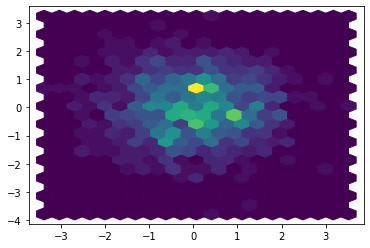

In [22]:
import plotly.offline as offline
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def compute_hexbin(x, y, gridsize=100, bins=None, cmap=plt.cm.Blues):
    """Computes the hexagonal binning
    """
    collection = plt.hexbin(x, y, bins=bins, gridsize=gridsize)
    plt.show()
    
    
#     plt.close()

#     pts_in_hexagon = collection.get_array()

#     #compute colors for the svg shapes
#     colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*cmap(Normalize()(pts_in_hexagon))]

#     # coordinates for single hexagonal patch
#     hx = [0, .5, .5, 0, -.5, -.5]
#     hy = [-.5/np.cos(np.pi/6), -.5*np.tan(np.pi/6), .5*np.tan(np.pi/6),
#           .5/np.cos(np.pi/6), .5*np.tan(np.pi/6), -.5*np.tan(np.pi/6)]

#     # number of hexagons needed
#     m = len(collection.get_offsets())

#     # scale of hexagons
#     n = (x.max() - x.min()) / gridsize

#     # y_scale to adjust for aspect ratio
#     y_scale = (y.max() - y.min())/(x.max() - x.min())

#     # coordinates for all hexagonal patches
#     hxs = np.array([hx]*m)*n + np.vstack(collection.get_offsets()[:,0])
#     hys = np.array([hy]*m)*n*y_scale + np.vstack(collection.get_offsets()[:,1])

#     return hxs.tolist(), hys.tolist(), colors, pts_in_hexagon
    return [None, None, None, None]

N = 1000

random_x = np.random.randn(N)
random_y = np.random.randn(N)

# random_x=full_data_projected["longitude"]
# random_y=full_data_projected["latitude"]

x, y, color_list, pts_in_hexagon = compute_hexbin(random_x, random_y, gridsize=20)



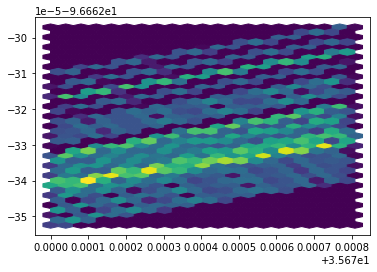

(array([ 35.66999991, -96.66234965]),
 array([10.,  3.,  0.,  9., 32., 10.,  9., 14.,  1.,  3.,  0.,  0.,  0.,
         6.,  3.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0., 15., 29., 36.,
        22., 18., 40.,  0., 14., 12.,  0., 10., 38., 13.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 15., 28., 19., 38., 19., 27., 27.,  0., 12.,
        19.,  7., 19., 26.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0., 27.,
        18., 13., 19., 44., 28., 19., 26., 19., 16., 18., 13.,  0.,  0.,
         9., 18.,  0.,  0.,  0.,  0.,  0., 19., 14.,  0., 27., 52., 18.,
        24., 36., 11., 18., 14.,  0.,  0., 12., 19., 14.,  0.,  0.,  0.,
         0.,  0., 14.,  0., 16., 25., 38., 26., 19., 39.,  0., 14., 14.,
         0.,  4., 38., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16., 20.,
        18., 40., 18., 26., 25.,  0., 14., 18.,  1., 18., 28.,  0.,  0.,
         7.,  0.,  0.,  0.,  0.,  0., 18., 18., 14., 18., 43., 21., 19.,
        28., 17.,  2., 18., 15.,  0.,  0.,  4., 18.,  0.,  0.,  0.,  0.,
         0., 

In [36]:
x = full_data_projected["latitude"]
y = full_data_projected["longitude"]

cmap=plt.cm.Blues
# grid_x=
# grid_y=
collection = plt.hexbin(x, y, bins=None, gridsize=(20,20))
plt.show()
# print(collection.properties())
pts_in_hexagon = collection.get_array()
# pts_in_hexagon
collection.get_offsets()[1],collection.get_array()
# [collection.get_offsets()[0,0][0], collection.get_offsets()[0,1][0]],[collection.get_offsets()[0,0][1], collection.get_offsets()[0,1][1]]

In [25]:
# ! pip install shapely

In [26]:
# oklahama=>epsg(2267)

In [27]:
[ 35.66999991, -96.66235242],
[ 35.66999991, -96.66234965]

[35.66999991, -96.66234965]

In [28]:
def values_inside(list_of_coordinates, dataframe):
    dataframe[(dataframe["latitude"]>=p[0])&
              (dataframe["latitude"]>=p[0])
             ]

In [30]:
points=[[ 35.66999991, -96.66235242],
       [ 35.66999991, -96.66235242],
       [ 35.66999991, -96.66235242],
       [ 35.66999991, -96.66235242],
       [ 35.66999991, -96.66235242],
       [ 35.66999991, -96.66235242]]

df=full_data_projected

poly=Polygon(points)

In [31]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

df['point'] = df.apply(lambda row: Point(row['latitude'],row['longitude']),axis=1)
polygon = Polygon(points)
df_1 = df[df['point'].apply(polygon.contains)].copy()


In [32]:
df_1

,Unnamed: 0,Unnamed: 0.1,timestamp,total_power,p0,p1,p2,p3,p4,p5,...,cluster,pass_no,latitude,longitude,prev,change,first,last,heading,point


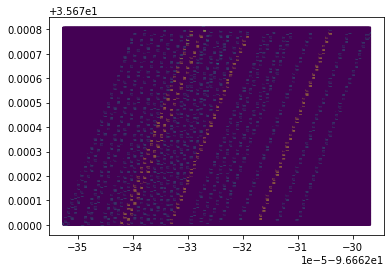

35.67080825082508 35.669999909952686 -96.66229709273654 -96.66235241527075
267048 6 [-96.6623524152708, -96.66235211460486, -96.66235211460486, -96.6623524152708, -96.66235271593675, -96.66235271593675] [35.669994837172034, 35.66999737356236, 35.67000244634301, 35.67000498273334, 35.67000244634301, 35.66999737356236] [-96.66229709273648, -96.66229679207053, -96.66229679207053, -96.66229709273648, -96.66229739340243, -96.66229739340243] [35.67080317804443, 35.670805714434756, 35.67081078721541, 35.670813323605735, 35.67081078721541, 35.670805714434756]


In [33]:
import plotly.offline as offline
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from pprint import pprint



def compute_hexbin(x, y, delta_x, delta_y, gridsize, bins=None, cmap=plt.cm.Blues):
    """Computes the hexagonal binning
    """

    collection = plt.hexbin(x, y, bins=bins, gridsize=gridsize)
    plt.show()
#     plt.close()
#     print(collection.getmembers())
#     pprint(vars(collection))

    pts_in_hexagon = collection.get_array()
#     print("pts_in_hexagon/n",pts_in_hexagon)

    #compute colors for the svg shapes
    colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*cmap(Normalize()(pts_in_hexagon))]

    # number of hexagons needed
    m = len(collection.get_offsets())
    
    print(y.max(),y.min(),x.max(),x.min())

    # scale of hexagons
    try:
        n = (x.max() - x.min()) / gridsize[0]
    except:
        n=(x.max() - x.min()) / gridsize

    # y_scale to adjust for aspect ratio
    y_scale = (y.max() - y.min())/(x.max() - x.min())
    
    # coordinates for single hexagonal patch
    hx =  [x  for x in [0, .5, .5, 0, -.5, -.5]]
    hy = [x  for x in [-.5/np.cos(np.pi/6), -.5*np.tan(np.pi/6), .5*np.tan(np.pi/6),
          .5/np.cos(np.pi/6), .5*np.tan(np.pi/6), -.5*np.tan(np.pi/6)]]

    # coordinates for all hexagonal patches
    hxs = np.array([hx]*m)*n + np.vstack(collection.get_offsets()[:,0])
    hys = np.array([hy]*m)*n*y_scale + np.vstack(collection.get_offsets()[:,1])

    return hxs.tolist(), hys.tolist(), colors, pts_in_hexagon

# N = 1000

# random_x = np.random.randn(N)
# random_y = np.random.randn(N)

def implement_hexplot(data,delta_x=0.0000006,delta_y=0.00000056):
    random_x = data["longitude"]
    random_y = data["latitude"]
    
    gridsize_x=int((random_x.max() - random_x.min())//delta_x)
    gridsize_y=int((random_y.max() - random_y.min())//delta_y)
    gridsize=(gridsize_x,gridsize_y)

    x, y, color_list, pts_in_hexagon = compute_hexbin(random_x, random_y, delta_x,delta_y, gridsize)

    print(len(x),len(x[0]),min(x),min(y),max(x),max(y))

    shape_container = []
    hover_point_x = []
    hover_point_y = []

    for x_list, y_list, color in zip(x, y, color_list):

        #Create the svg path based on the computed points

        svg_path = 'M {},{} L {},{} L {},{} L {},{} L{},{} L{},{}'\
            .format(x_list[0], y_list[0],
                    x_list[1], y_list[1],
                    x_list[2], y_list[2],
                    x_list[3], y_list[3],
                    x_list[4], y_list[4],
                    x_list[4], y_list[1])

        #Create hover point from the hexagon, witch is the center of gravity
        hover_point_x.append(round((max(x_list) - min(x_list))/2+min(x_list), 2))
        hover_point_y.append(round((max(y_list) - min(y_list))/2+min(y_list), 2))

        shape_container.append({
              "fillcolor": color,
              "line": {
                "color": color,
                "width": 1.5
              },
              "path": svg_path,
              "type": "path"
            })

    trace = go.Scattergl(x=hover_point_x,
                       y=hover_point_y,
                       mode='markers'
                       )

    trace['marker']['colorbar'] = {"title": "Amount of points"}
    trace['marker']['reversescale'] = True
    trace['marker']['colorscale'] = 'Blues'
    trace['marker']['color'] = pts_in_hexagon
    trace['marker']['size'] = 0
    trace['text'] = list(map(lambda z: 'Amount of points: {}'.format(int(z)), pts_in_hexagon))

    layout = {'shapes':shape_container,
              'width': 850,
              'height': 700,
              'hovermode':'closest'}

    fig = dict(data=[trace], layout=layout)

    offline.plot(fig)
    


implement_hexplot(full_data_projected)
 